## Plot the regional time evolution of total column ozone

Plotting annual mean for 60S to 60N.

In [1]:
import cf
import cfplot as cfp
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

In [2]:
# define the locations of the various datasets
# CCMI2022 refD1 ensemble
ensdata='/home/ubuntu/Tutorials/UMvn13.0/data/toz_Amon_UKESM1-StratTrop_refD1_r?i1p1f2_gn_19600101-20190101.nc'
# CCMI1 refC1
ccmidata='/home/ubuntu/Tutorials/UMvn13.0/data/toz_monthly_UMUKCA-UCAM_refC1_r1i1p1_*.nc'
# UKCA model data from ACSIS project, nudged to ERA5
ukcadata='/home/ubuntu/Tutorials/UMvn13.0/data/u-*/apm.pp/*.pp'
# Bodeker Scientific TCO dataset - https://www.bodekerscientific.com/data/total-column-ozone
# this has been preprocessed into a single file using ncks, ncatted, and ncrcat
# for i in `ls *.nc`; do echo $i; ncks -O --mk_rec_dmn time $i $i; done
# for i in `ls *.nc`; do echo $i; ncatted -O -a created,global,d,, $i; done
# for i in `ls *.nc`; do echo $i; ncatted -O -a units,longitude,o,c,degrees_east $i; done
# for i in `ls *.nc`; do echo $i; ncatted -O -a units,latitude,o,c,degrees_north $i; done
# ncrcat BSFilledTCO_V3.4.1_????_Monthly.nc ../BSFilledTCO_V3.4.1_Monthly.nc
obsdata='/home/ubuntu/Tutorials/UMvn13.0/data/Bodeker_3.4.1/*.nc'
# We would like to thank Bodeker Scientific, funded by the New Zealand Deep South National 
# Science Challenge, for providing the combined NIWA-BS total column ozone database.

In [3]:
# CCMI2022 data is in units of m rather than Dobson units, so will need to convert later
duconv=1.0e5

In [4]:
# read-in the data
# 3x ensemble members for CCMI2022
inens=cf.read(ensdata, select='equivalent_thickness_at_stp_of_atmosphere_ozone_content')

# 10-year files for CCMI1
ccmi=cf.read(ccmidata, select='equivalent_thickness_at_stp_of_atmosphere_ozone_content')[0]

# pp-files for UKCA, individual files
ukca=cf.read(ukcadata,select='stash_code=50219')[0]

# Bodeker Total Column Ozone dataset - **preprocessed**
obs=cf.read(obsdata, select='equivalent_thickness_at_stp_of_atmosphere_ozone_content')[0]

In [5]:
# function to calculate means over latitude bands
def mask_region_mean(inf,lower_lat=-60.0,higher_lat=60.0):
    f=inf.copy()

    # create bounds
    # longitude
    if not f.coord('X').has_bounds():
        bounds = f.coord('X').create_bounds()
        f.coord('X').set_bounds(bounds)
    # latitude
    if not f.coord('Y').has_bounds():
        bounds = f.coord('Y').create_bounds()
        f.coord('Y').set_bounds(bounds)

    # remove regions that are outside of the allowed latitudes
    # - set these regions to large negative number for masking    
    for i in range(f.coordinate('latitude').array.shape[0]):
        if f.coordinate('latitude').array[i] < lower_lat or f.coordinate('latitude').array[i] > higher_lat:
            # TCO is a 3D field, T,Y,X
            f.data[:,i,:] = -999.0
    
    # remove invalid points using masked array
    f.data=ma.masked_less(f.data,0.0)
    
    # collapse doing an area mean and weighting by the surface area
    f_mean = f.collapse('area: mean', weights=True)
            
    return f_mean
    del f
    del f_mean

In [6]:
# consider region - 60s to 60N
llat=-60.0
hlat=60.0

# needed for annual mean calculation
y = cf.Y(month=12)

# ensemble from CCMI2022
ens=cf.FieldList()
for f in inens:
    # delete auxillary coordinates as these might cause problems with some operations
    f.del_construct('forecast_period')
    f.del_construct('forecast_reference_time')
    f=mask_region_mean(f,lower_lat=llat,higher_lat=hlat).squeeze()
    # convert to DU for this set of data
    f.data=f.data/duconv
    f.override_units('DU', inplace=True)
    # calculate annual mean
    f=f.collapse('T: mean', group=y)
    ens.append(f)
    
# CCMI1
ccmi=mask_region_mean(ccmi,lower_lat=llat,higher_lat=hlat).squeeze()
ccmi=ccmi.collapse('T: mean', group=y)

# Nudged ACSIS run
ukca=mask_region_mean(ukca,lower_lat=llat,higher_lat=hlat).squeeze()
ukca=ukca.collapse('T: mean', group=y)

# Obs
# need to put bounds on the time axis to be able to collapse for an annual mean
if not obs.coord('T').has_bounds():
    bounds = obs.coord('T').create_bounds()
    obs.coord('T').set_bounds(bounds)
obs=mask_region_mean(obs,lower_lat=llat,higher_lat=hlat).squeeze()
obs=obs.collapse('T: mean', group=y)

In [7]:
# normalise calendars

# CCMI2022
for f in inens:
    f.coordinate('time').set_property('units','days since 1960-01-01')
    f.coordinate('time').set_property('calendar','360_day')
    
# CCMI1
ccmi.coordinate('time').set_property('units','days since 1960-01-01')
ccmi.coordinate('time').set_property('calendar','360_day')

# these are Gregorian calendar, do a rough conversion

# nudged data
ukca.coordinate('time').set_property('units','days since 1960-01-01')
ukca.coordinate('time').override_calendar('360_day')
ukca.coordinate('time').set_data(ukca.coordinate('time').array*(360.0/365.24))

# Obs data
obs.coordinate('time').set_property('units','days since 1960-01-01')
obs.coordinate('time').override_calendar('360_day')
obs.coordinate('time').set_data(obs.coordinate('time').array*(360.0/365.24))

In [8]:
# calculate ensemble mean and standard deviation
arr=np.zeros((len(ens[0].data),len(ens),))
for i in range(len(ens)):
    arr[:,i]=ens[i].array[:]
darr=np.mean(arr,axis=1)
dstd=np.std(arr,axis=1)
# give error envelope as 2 standard error (2.0*std/sqrt(ensemble size))
dstderr=2.0*dstd/np.sqrt(len(ens))
# save to a cube for plotting
ensmean=ens[0].copy()
ensmean.data=darr

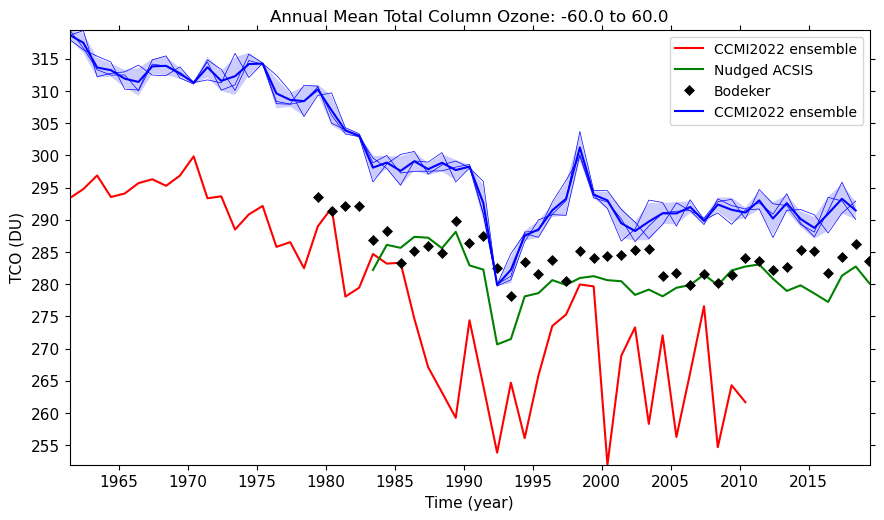

In [9]:
# Now plot the data

# make the plot a bit wider
cfp.gopen(figsize=(10,5))

# CCMI1 REF-C1
cfp.lineplot(ccmi,color='r',linewidth=1.5, label='CCMI2022 ensemble')

# Nudged ACSIS UKCA run
cfp.lineplot(ukca,color='g',linewidth=1.5, label='Nudged ACSIS')

# Bodeker observations
cfp.lineplot(obs,color='k',lines=False, marker='D', label='Bodeker')

# CCMI2022 ensemble last as cf-plot only plots the dates from the last line plotted
# plot the ensemble member lines for reference
for f in ens:
    cfp.lineplot(f,color='b',linewidth=0.5)
# plot the ensemble mean
cfp.lineplot(ensmean,color='b',linewidth=1.5, label='CCMI2022 ensemble')
# plot 2x standard error as a shaded envelope
cfp.plotvars.plot.fill_between(ensmean.coord('time'),ensmean-dstderr,ensmean+dstderr, alpha=0.2, color='b', edgecolor=None)

# plot title with some descriptive information
plt.title('Annual Mean Total Column Ozone: '+str(llat)+' to '+str(hlat))
plt.ylabel('TCO (DU)')
# include legend
plt.legend()
cfp.gclose()